In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/santander-customer-satisfaction/sample_submission.csv
/kaggle/input/santander-customer-satisfaction/test.csv
/kaggle/input/santander-customer-satisfaction/train.csv


In [2]:
from sklearn import feature_selection
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.feature_selection import VarianceThreshold
import collections
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.model_selection import ParameterGrid
from imblearn.over_sampling import ADASYN

In [3]:
train=pd.read_csv("../input/santander-customer-satisfaction/train.csv",index_col="ID")
test_X=pd.read_csv("../input/santander-customer-satisfaction/test.csv",index_col="ID")

# DATASET ANALYSIS

In [4]:
train.describe()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,3.160715,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,95.268204,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,8237.820000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76020 entries, 1 to 151838
Columns: 370 entries, var3 to TARGET
dtypes: float64(111), int64(259)
memory usage: 215.2 MB


In [6]:
test_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75818 entries, 2 to 151837
Columns: 369 entries, var3 to var38
dtypes: float64(110), int64(259)
memory usage: 214.0 MB


All features are numeric

In [7]:
train.isnull().sum().sum()

0

In [8]:
test_X.isnull().sum().sum()

0

There is no missing data in both test, train set

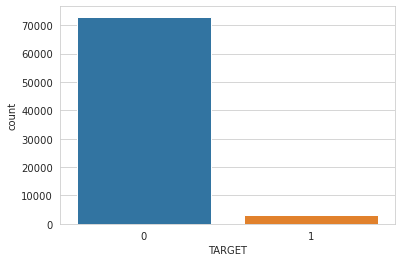

In [9]:
sns.set_style("whitegrid")
sns.countplot(x="TARGET",data=train)

In [10]:
df=pd.DataFrame(train.TARGET.value_counts())
df['percentage']=100*df['TARGET']/train.shape[0]
df

,TARGET,percentage
0,73012,96.043147
1,3008,3.956853


Huge Class Imbalance as shown above

For detailed EDA please see https://www.kaggle.com/cast42/exploring-features#Clusters

# DATA CLEANING

In [11]:
# -999999 in var 3 means unkown so we are replacing it with the most common value in var3
train.var3 = train.var3.replace(-999999,2)
test_X.var3 = test_X.var3.replace(-999999,2)

In [12]:
train.loc[train.var3==-999999].shape

(0, 370)

In [13]:
test_X.loc[test_X.var3==-999999].shape

(0, 369)

Validation & Train set Split

In [14]:
train_X, val_X, train_y, val_y = train_test_split(train.drop(labels=['TARGET'], axis=1),train['TARGET'],test_size=0.2,random_state=1)

*Feature Variance Analysis*

In [15]:
#Use Variance Thereshold to remove both constant,quasi-constant features
selector = VarianceThreshold(threshold=0.01)

In [16]:
selector.fit(train_X)

VarianceThreshold(threshold=0.01)

In [17]:
constArr=selector.get_support()

In [18]:
constCol=[col for col in train_X.columns if col not in train_X.columns[constArr]]

In [19]:
# constant features
constCol

['ind_var1',
 'ind_var2_0',
 'ind_var2',
 'ind_var6_0',
 'ind_var6',
 'ind_var13_medio_0',
 'ind_var13_medio',
 'ind_var14',
 'ind_var17_0',
 'ind_var17',
 'ind_var18_0',
 'ind_var18',
 'ind_var19',
 'ind_var20_0',
 'ind_var20',
 'ind_var27_0',
 'ind_var28_0',
 'ind_var28',
 'ind_var27',
 'ind_var29_0',
 'ind_var29',
 'ind_var30_0',
 'ind_var31_0',
 'ind_var31',
 'ind_var32_cte',
 'ind_var32_0',
 'ind_var32',
 'ind_var33_0',
 'ind_var33',
 'ind_var34_0',
 'ind_var34',
 'ind_var40',
 'ind_var41',
 'ind_var39',
 'ind_var44_0',
 'ind_var44',
 'ind_var46_0',
 'ind_var46',
 'num_var6_0',
 'num_var6',
 'num_var13_medio_0',
 'num_var13_medio',
 'num_var18_0',
 'num_var18',
 'num_var27_0',
 'num_var28_0',
 'num_var28',
 'num_var27',
 'num_var29_0',
 'num_var29',
 'num_var33',
 'num_var34_0',
 'num_var34',
 'num_var41',
 'num_var46_0',
 'num_var46',
 'saldo_var28',
 'saldo_var27',
 'saldo_var41',
 'saldo_var46',
 'imp_amort_var18_hace3',
 'imp_amort_var34_hace3',
 'imp_reemb_var13_hace3',
 'imp

In [20]:
#check
train_X.ind_var2_0.unique()

array([0])

In [21]:
#dropping constant features from train,test,val set
train_X.drop(columns=constCol,axis=1,inplace=True)
test_X.drop(columns=constCol,axis=1,inplace=True)
val_X.drop(columns=constCol,axis=1,inplace=True)

In [22]:
print(train_X.shape)
print(test_X.shape)
print(val_X.shape)

(60816, 273)
(75818, 273)
(15204, 273)


*Remove Duplicate features*

In [23]:
def duplicateColumns(data):
    dupliCols=[]
    for i in range(0,len(data.columns)):
        col1=data.columns[i]
        for col2 in data.columns[i+1:]:
            if data[col1].equals(data[col2]):
                dupliCols.append(col1+','+col2)
    return dupliCols

In [24]:
dupCol=duplicateColumns(train_X)
dCols=[col.split(',')[1] for col in dupCol]
dCols

['ind_var26',
 'ind_var25',
 'ind_var37',
 'num_var26',
 'num_var25',
 'num_var32',
 'num_var37',
 'num_var39',
 'saldo_var29',
 'saldo_medio_var13_medio_ult1',
 'delta_num_reemb_var13_1y3',
 'delta_num_reemb_var17_1y3',
 'delta_num_reemb_var33_1y3',
 'delta_num_trasp_var17_in_1y3',
 'delta_num_trasp_var17_out_1y3',
 'delta_num_trasp_var33_in_1y3',
 'delta_num_trasp_var33_out_1y3']

In [25]:
dupCol

['ind_var26_0,ind_var26',
 'ind_var25_0,ind_var25',
 'ind_var37_0,ind_var37',
 'num_var26_0,num_var26',
 'num_var25_0,num_var25',
 'num_var32_0,num_var32',
 'num_var37_0,num_var37',
 'num_var40,num_var39',
 'saldo_var6,saldo_var29',
 'saldo_var13_medio,saldo_medio_var13_medio_ult1',
 'delta_imp_reemb_var13_1y3,delta_num_reemb_var13_1y3',
 'delta_imp_reemb_var17_1y3,delta_num_reemb_var17_1y3',
 'delta_imp_reemb_var33_1y3,delta_num_reemb_var33_1y3',
 'delta_imp_trasp_var17_in_1y3,delta_num_trasp_var17_in_1y3',
 'delta_imp_trasp_var17_out_1y3,delta_num_trasp_var17_out_1y3',
 'delta_imp_trasp_var33_in_1y3,delta_num_trasp_var33_in_1y3',
 'delta_imp_trasp_var33_out_1y3,delta_num_trasp_var33_out_1y3']

delete the any oen of them will be fine but we decide to delete the first column

In [26]:
dCols=list(set(dCols))

In [27]:
train_X.drop(columns=dCols,axis=1,inplace=True)
val_X.drop(columns=dCols,axis=1,inplace=True)
test_X.drop(columns=dCols,axis=1,inplace=True)

*Removing Features that are highly correlated to each other*

In [28]:
def correlation(dataset,threshold):
    col_corr=set() # set will contains unique values.
    corr_matrix=dataset.corr() #finding the correlation between columns.
    for i in range(len(corr_matrix.columns)): #number of columns
        for j in range(i):
            if abs(corr_matrix.iloc[i,j])>threshold: #checking the correlation between columns.
                colName=corr_matrix.columns[i] #getting the column name
                col_corr.add(colName) #adding the correlated column name heigher than threshold value.
    return col_corr #returning set of column names

In [29]:
corrCol=list(correlation(train_X,0.8))

In [30]:
len(corrCol)

129

In [31]:
train_X.drop(columns=corrCol,axis=1,inplace=True)
val_X.drop(columns=corrCol,axis=1,inplace=True)
test_X.drop(columns=corrCol,axis=1,inplace=True)

We have finished using filter method to select features

*Scale the data*

In [32]:
scaler=StandardScaler()

In [33]:
train_sca_X = scaler.fit_transform(train_X)
test_sca_X = scaler.transform(test_X)
val_sca_X = scaler.transform(val_X)

# Oversample Data

*oversample data with smote*

In [34]:
pd.DataFrame(train_sca_X,columns=train_X.columns,index=train_X.index)

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var40_comer_ult1,imp_op_var40_efect_ult1,imp_op_var40_ult1,imp_op_var41_efect_ult1,imp_sal_var16_ult1,ind_var1_0,...,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var33_hace3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,var38
ID,,,,,,,,,,,,,,,,,,,,,
259,-0.075606,0.214268,-0.052943,-0.211739,-0.039239,-0.014699,-0.033532,-0.131559,-0.011209,-0.108530,...,-0.060453,-0.03577,-0.018104,-0.008567,-0.005696,-0.004055,-0.011406,-0.014911,-0.01245,-0.322046
117643,-0.075606,-0.326498,-0.052943,-0.211739,-0.039239,-0.014699,-0.033532,-0.131559,-0.011209,-0.108530,...,-0.060453,-0.03577,-0.018104,-0.008567,-0.005696,-0.004055,-0.011406,-0.014911,-0.01245,-0.097785
40380,-0.075606,0.137016,-0.052943,1.682257,-0.039239,-0.014699,-0.033532,1.058449,-0.011209,9.214028,...,-0.060453,-0.03577,-0.018104,-0.008567,-0.005696,-0.004055,-0.011406,-0.014911,-0.01245,-0.001145
125311,-0.075606,-0.790012,-0.052943,-0.211739,-0.039239,-0.014699,-0.033532,-0.131559,-0.011209,-0.108530,...,-0.060453,-0.03577,-0.018104,-0.008567,-0.005696,-0.004055,-0.011406,-0.014911,-0.01245,-0.063606
87074,-0.075606,-0.790012,-0.052943,-0.211739,-0.039239,-0.014699,-0.033532,-0.131559,-0.011209,-0.108530,...,-0.060453,-0.03577,-0.018104,-0.008567,-0.005696,-0.004055,-0.011406,-0.014911,-0.01245,0.147551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41285,-0.075606,0.059763,0.417347,1.046271,-0.039239,-0.014699,-0.033532,0.344444,-0.011209,-0.108530,...,-0.060453,-0.03577,-0.018104,-0.008567,-0.005696,-0.004055,-0.011406,-0.014911,-0.01245,-0.307591
42939,-0.075606,-0.481003,-0.052943,-0.211739,-0.039239,-0.014699,-0.033532,-0.131559,-0.011209,-0.108530,...,-0.060453,-0.03577,-0.018104,-0.008567,-0.005696,-0.004055,-0.011406,-0.014911,-0.01245,-0.001145
146454,-0.075606,-0.249246,1.059473,-0.211739,-0.039239,-0.014699,-0.033532,-0.131559,-0.011209,-0.108530,...,-0.060453,-0.03577,-0.018104,-0.008567,-0.005696,-0.004055,-0.011406,-0.014911,-0.01245,2.818102


In [35]:
sm = SMOTE(random_state=42)
train_res_X, train_res_y = sm.fit_resample(train_sca_X, train_y)

In [36]:
train_res_y.value_counts()

1    58411
0    58411
Name: TARGET, dtype: int64

# Modelling with xgboost

In [37]:
baseline_xgb_clf = XGBClassifier(random_state=20)

In [38]:
baseline_xgb_clf.fit(train_res_X,train_res_y,early_stopping_rounds=20,eval_metric="auc",eval_set=[(val_sca_X, val_y)])

[0]	validation_0-auc:0.80285
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.81442
[2]	validation_0-auc:0.81664
[3]	validation_0-auc:0.81857
[4]	validation_0-auc:0.81757
[5]	validation_0-auc:0.81855
[6]	validation_0-auc:0.81872
[7]	validation_0-auc:0.81821
[8]	validation_0-auc:0.81827
[9]	validation_0-auc:0.81822
[10]	validation_0-auc:0.81720
[11]	validation_0-auc:0.81441
[12]	validation_0-auc:0.81358
[13]	validation_0-auc:0.81112
[14]	validation_0-auc:0.81195
[15]	validation_0-auc:0.81085
[16]	validation_0-auc:0.80955
[17]	validation_0-auc:0.80778
[18]	validation_0-auc:0.80574
[19]	validation_0-auc:0.80487
[20]	validation_0-auc:0.80441
[21]	validation_0-auc:0.80317
[22]	validation_0-auc:0.80368
[23]	validation_0-auc:0.80164
[24]	validation_0-auc:0.80096
[25]	validation_0-auc:0.79970
[26]	validation_0-auc:0.79830
Stopping. Best iteration:
[6]	validation_0-auc:0.81872



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=20,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [39]:
pred_y = baseline_xgb_clf.predict_proba(val_sca_X)[:,1]

In [40]:
roc_auc_score(val_y,pred_y)

0.8187239952555556

The Above Model has performed relatively well. Let's see if we could improve results by hyperparameter tuning

# Hyperparameter Tuning

Using Grid Search Cross Validation to find best hyperparameters

In [41]:
# param_grid = {"learning_rate"    : [0.05, 0.10] ,
#  "max_depth"        : [5, 6, 8, 10],
#  "min_child_weight" : [ 1, 3, 5],
#  "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4],
#  "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

In [42]:
xgb_clf=XGBClassifier()

In [43]:
# best_score=0
# for g in ParameterGrid(param_grid):
#      xgb_clf.set_params(**g)
#      xgb_clf.fit(train_res_X,train_res_y,early_stopping_rounds=20,eval_metric="auc",eval_set=[(val_sca_X, val_y)])
#      pred_y = xgb_clf.predict_proba(val_sca_X)[:,1]
#      score=roc_auc_score(val_y,pred_y)
#      if score > best_score:
#          best_score = roc_auc_score(val_y,pred_y)
#          best_grid = g

In [44]:
best_grid={'colsample_bytree': 0.7,
 'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 6,
 'min_child_weight': 1}

In [45]:
xgb_clf.set_params(**best_grid)
xgb_clf.fit(train_res_X,train_res_y,early_stopping_rounds=20,eval_metric="auc",eval_set=[(val_sca_X, val_y)])

[0]	validation_0-auc:0.81548
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.81741
[2]	validation_0-auc:0.81953
[3]	validation_0-auc:0.81914
[4]	validation_0-auc:0.82291
[5]	validation_0-auc:0.82408
[6]	validation_0-auc:0.82565
[7]	validation_0-auc:0.82503
[8]	validation_0-auc:0.82430
[9]	validation_0-auc:0.82427
[10]	validation_0-auc:0.82454
[11]	validation_0-auc:0.82480
[12]	validation_0-auc:0.82524
[13]	validation_0-auc:0.82568
[14]	validation_0-auc:0.82563
[15]	validation_0-auc:0.82516
[16]	validation_0-auc:0.82431
[17]	validation_0-auc:0.82456
[18]	validation_0-auc:0.82501
[19]	validation_0-auc:0.82455
[20]	validation_0-auc:0.82418
[21]	validation_0-auc:0.82379
[22]	validation_0-auc:0.82300
[23]	validation_0-auc:0.82239
[24]	validation_0-auc:0.82212
[25]	validation_0-auc:0.82198
[26]	validation_0-auc:0.82186
[27]	validation_0-auc:0.82179
[28]	validation_0-auc:0.82149
[29]	validation_0-auc:0.82145
[30]	validation_0-auc:0.82145
[31]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

We have finished hyperparameter tuning. Now we should make a prediction on the test set

In [46]:
pred_y = xgb_clf.predict_proba(test_sca_X)[:,1]

In [47]:
subs = pd.DataFrame(({'ID': test_X.index, 'TARGET': pred_y}))

Another set of grid search to find best hyperparameter

In [48]:
param_grid = {"learning_rate"    : [0.03] ,
  "max_depth"        : [6],
 "min_child_weight" : [ 0,1],
 "gamma"            : [ 0.1],
"n_estimators": [150,200,250],
"colsample_bytree" : [ 0.8,0.85] }

In [49]:
len(list(ParameterGrid(param_grid)))

12

In [50]:
best_score=0
for g in ParameterGrid(param_grid):
    xgb_clf.set_params(**g)
    xgb_clf.fit(train_res_X,train_res_y,early_stopping_rounds=20,eval_metric="auc",eval_set=[(val_sca_X, val_y)])
    pred_y = xgb_clf.predict_proba(val_sca_X)[:,1]
    score=roc_auc_score(val_y,pred_y)
    if score > best_score:
        best_score = roc_auc_score(val_y,pred_y)
        best_grid = g

[0]	validation_0-auc:0.81541
Will train until validation_0-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.81453
[2]	validation_0-auc:0.81730
[3]	validation_0-auc:0.81483
[4]	validation_0-auc:0.81791
[5]	validation_0-auc:0.81922
[6]	validation_0-auc:0.82002
[7]	validation_0-auc:0.82037
[8]	validation_0-auc:0.82085
[9]	validation_0-auc:0.82128
[10]	validation_0-auc:0.82196
[11]	validation_0-auc:0.82220
[12]	validation_0-auc:0.82187
[13]	validation_0-auc:0.82178
[14]	validation_0-auc:0.82193
[15]	validation_0-auc:0.82245
[16]	validation_0-auc:0.82293
[17]	validation_0-auc:0.82287
[18]	validation_0-auc:0.82280
[19]	validation_0-auc:0.82301
[20]	validation_0-auc:0.82283
[21]	validation_0-auc:0.82336
[22]	validation_0-auc:0.82392
[23]	validation_0-auc:0.82441
[24]	validation_0-auc:0.82474
[25]	validation_0-auc:0.82489
[26]	validation_0-auc:0.82503
[27]	validation_0-auc:0.82518
[28]	validation_0-auc:0.82491
[29]	validation_0-auc:0.82490
[30]	validation_0-auc:0.82506
[31]	validation_

In [51]:
best_score

0.8262163828711612

In [52]:
best_grid

{'colsample_bytree': 0.8,
 'gamma': 0.1,
 'learning_rate': 0.03,
 'max_depth': 6,
 'min_child_weight': 1,
 'n_estimators': 150}

In [53]:
# best_grid2={'colsample_bytree': 0.8,
# 'gamma': 0.0,
#  'learning_rate': 0.03,
#  'max_depth': 6,
#  'min_child_weight': 1,
#  'n_estimators': 350}

In [54]:
#best_score2=0.8262192223595399

In [55]:
#subs.to_csv('submission.csv', index=False)

We arrive at 0.8265 accuracy it is not the best I might come back at this problem later. But it should be a fairly good notebook to show we tackle imbalanced class classification problem